# Set-up

In [1]:
import sys
sys.path.append("..")

#%%
# named packages
import argparse
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import cloudpickle
from pathlib import Path
from collections import Counter
from src import RESULTS_DIR
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from utils.hash import decode_id
from utils.plotting import plot_pr_curve_subplot
from utils.plotting import plot_pr_curve
from utils.plotting import plotsize
from utils.evaluation import f1_smart
from src.datasets import AmarettoDataset
from utils.samplers import WeightedSampler

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

original_lineplot = sns.lineplot  # Save original function

def patched_lineplot(*args, **kwargs):
    kwargs.setdefault('estimator', None)
    return original_lineplot(*args, **kwargs)

sns.lineplot = patched_lineplot  # Replace Seaborn's function

## Data

Load data, shapes and labels.

In [3]:
# train_dataset = AmarettoDataset(split="train")
val_dataset = AmarettoDataset(split="val")
test_dataset = AmarettoDataset(split="test")

val_labels = val_dataset.labels
val_anomaly = val_dataset.anomaly

test_labels = test_dataset.labels
test_anomaly = test_dataset.anomaly

feature_names = test_dataset.costly_features.columns[3:]

## Get dimensions

sampler = WeightedSampler(labels=val_dataset.labels, positive_ratio=0.25, max_num_samples=100)
dl = DataLoader(val_dataset, batch_size=32, sampler=sampler, drop_last=True)

for batch in dl:
    break

c, p, y = batch
n_prior_features = p.shape[1]
n_costly_features = c.shape[1]

# del val_dataset, test_dataset
# import gc
# gc.collect()

In [4]:
from src.datasets import AmarettoLabels


labels_train = AmarettoLabels(split='train')
labels_val = AmarettoLabels(split='val')
labels_test = AmarettoLabels(split='test')

In [5]:
len(np.hstack([labels_train.anomaly, labels_val.anomaly, labels_test.anomaly]))

29704090

In [6]:
Counter(np.hstack([labels_train.anomaly, labels_val.anomaly, labels_test.anomaly]))

Counter({np.int64(0): 29622822,
         np.int64(4): 30640,
         np.int64(5): 30080,
         np.int64(3): 12088,
         np.int64(1): 5884,
         np.int64(2): 2576})

In [7]:
Counter(np.hstack([labels_train.labels, labels_val.labels, labels_test.labels]))

Counter({np.int64(0): 29622822, np.int64(1): 81268})

In [8]:
np.mean(np.hstack([labels_train.labels, labels_val.labels, labels_test.labels]))

np.float64(0.0027359195316200564)

In [9]:
n_prior_features, n_costly_features

(34, 91)

# Classifier results

## Full feature set

In [10]:
best_model = RESULTS_DIR / "amaretto/nn_classifier_full_probabilities.pkl"

with open(best_model, 'rb') as f:
    best_results = cloudpickle.load(f)
    val_probabilities = best_results['val_probabilities']
    test_probabilities = best_results['test_probabilities']

models = {'full_classifier': (val_probabilities, test_probabilities)}

In [11]:
val_precision, val_recall, _ = precision_recall_curve(val_labels, val_probabilities)
test_precision, test_recall, _ = precision_recall_curve(test_labels, test_probabilities)

val_auc = auc(val_recall, val_precision)
test_auc = auc(test_recall, test_precision)

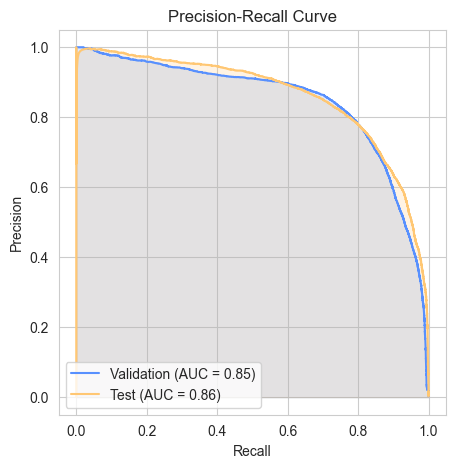

In [12]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.figure(figsize=(5, 5))

sns.lineplot(x=val_recall, y=val_precision, color='#5890FE', label=f'Validation (AUC = {val_auc:.2f})')
plt.fill_between(val_recall, val_precision, alpha=0.2, color='#5890FE')

sns.lineplot(x=test_recall, y=test_precision, color='#FFC773', label=f'Test (AUC = {test_auc:.2f})')
plt.fill_between(test_recall, test_precision, alpha=0.2, color='#FFC773')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [13]:
tmp = {
    'precision': [],
    'recall': [],
    'split': [],
    'anomaly': [],
}

for anomaly_type in range(1,6):
    b_val = np.array(val_anomaly == 0) | np.array(val_anomaly == anomaly_type)
    b_test = np.array(test_anomaly == 0) | np.array(test_anomaly == anomaly_type)
    
    val_precision, val_recall, _ = precision_recall_curve(val_labels[b_val], np.array(val_probabilities)[b_val])
    test_precision, test_recall, _ = precision_recall_curve(test_labels[b_test], np.array(test_probabilities)[b_test])
    
    tmp['precision'].extend(val_precision)
    tmp['recall'].extend(val_recall)
    tmp['split'].extend(['validation'] * len(val_precision))
    tmp['anomaly'].extend([anomaly_type] * len(val_precision))
    
    tmp['precision'].extend(test_precision)
    tmp['recall'].extend(test_recall)
    tmp['split'].extend(['test'] * len(test_precision))
    tmp['anomaly'].extend([anomaly_type] * len(test_precision))

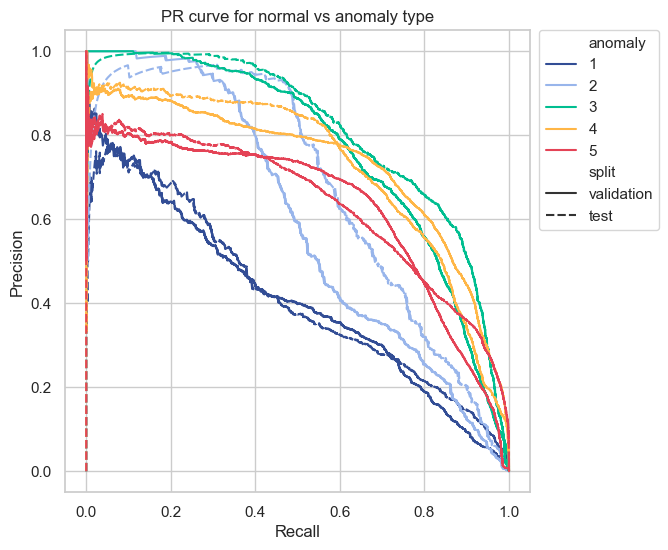

In [14]:
plotsize(6,6)
sns.set_style("whitegrid")

anomaly_df = pl.DataFrame(tmp)
sns.lineplot(
    data=anomaly_df, x='recall', y='precision', hue='anomaly', style='split',
    palette=sns.color_palette(['#324D95', '#98B5EB', '#00BE90', '#FFB646', '#E44356'])
)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve for normal vs anomaly type')
plt.show()

## 2 features classifier

In [15]:
best_model = RESULTS_DIR / "amaretto/nn_classifier_2f_probabilities.pkl"

with open(best_model, 'rb') as f:
    best_results = cloudpickle.load(f)
    val_probabilities = best_results['val_probabilities']
    test_probabilities = best_results['test_probabilities']
    
models['2f_classifier'] = (val_probabilities, test_probabilities)

In [16]:
val_precision, val_recall, _ = precision_recall_curve(val_labels, val_probabilities)
test_precision, test_recall, _ = precision_recall_curve(test_labels, test_probabilities)

val_auc = auc(val_recall, val_precision)
test_auc = auc(test_recall, test_precision)

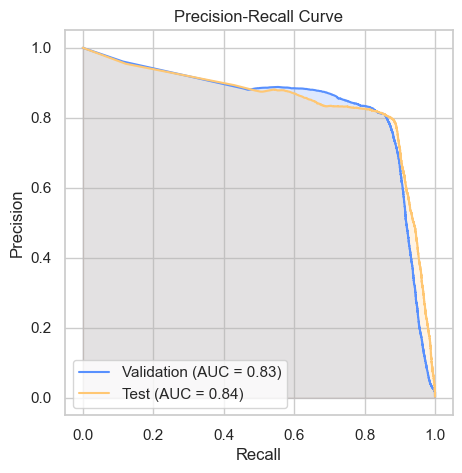

In [17]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.figure(figsize=(5, 5))

sns.lineplot(x=val_recall, y=val_precision, color='#5890FE', label=f'Validation (AUC = {val_auc:.2f})')
plt.fill_between(val_recall, val_precision, alpha=0.2, color='#5890FE')

sns.lineplot(x=test_recall, y=test_precision, color='#FFC773', label=f'Test (AUC = {test_auc:.2f})')
plt.fill_between(test_recall, test_precision, alpha=0.2, color='#FFC773')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [18]:
tmp = {
    'precision': [],
    'recall': [],
    'split': [],
    'anomaly': [],
}

for anomaly_type in range(1,6):
    b_val = np.array(val_anomaly == 0) | np.array(val_anomaly == anomaly_type)
    b_test = np.array(test_anomaly == 0) | np.array(test_anomaly == anomaly_type)
    
    val_precision, val_recall, _ = precision_recall_curve(val_labels[b_val], np.array(val_probabilities)[b_val])
    test_precision, test_recall, _ = precision_recall_curve(test_labels[b_test], np.array(test_probabilities)[b_test])
    
    tmp['precision'].extend(val_precision)
    tmp['recall'].extend(val_recall)
    tmp['split'].extend(['validation'] * len(val_precision))
    tmp['anomaly'].extend([anomaly_type] * len(val_precision))
    
    tmp['precision'].extend(test_precision)
    tmp['recall'].extend(test_recall)
    tmp['split'].extend(['test'] * len(test_precision))
    tmp['anomaly'].extend([anomaly_type] * len(test_precision))

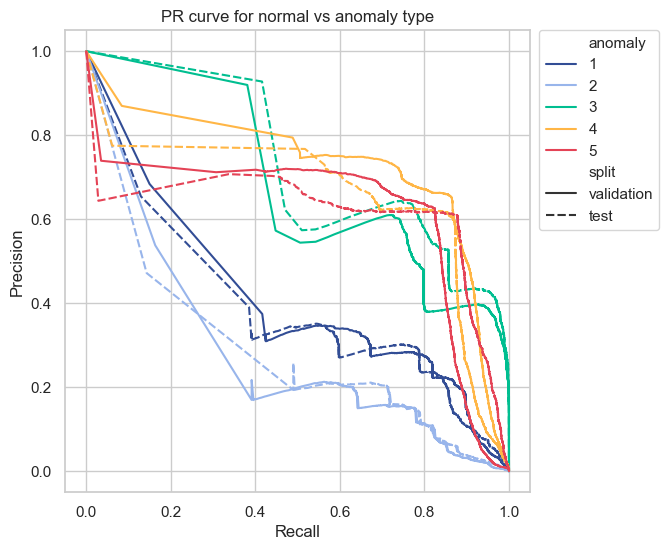

In [19]:
plotsize(6,6)
sns.set_style("whitegrid")

anomaly_df = pl.DataFrame(tmp)
sns.lineplot(
    data=anomaly_df, x='recall', y='precision', hue='anomaly', style='split',
    palette=sns.color_palette(['#324D95', '#98B5EB', '#00BE90', '#FFB646', '#E44356'])
)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve for normal vs anomaly type')
plt.show()

## Only prior features

In [20]:
best_prior_model = RESULTS_DIR / "amaretto/nn_classifier_prior_probabilities.pkl"

with open(best_prior_model, 'rb') as f:
    best_prior_results = cloudpickle.load(f)
    val_probabilities = best_prior_results['val_probabilities']
    test_probabilities = best_prior_results['test_probabilities']
    
models['prior_classifier'] = (val_probabilities, test_probabilities)    

In [21]:
val_precision, val_recall, _ = precision_recall_curve(val_labels, val_probabilities)
test_precision, test_recall, _ = precision_recall_curve(test_labels, test_probabilities)

val_auc = auc(val_recall, val_precision)
test_auc = auc(test_recall, test_precision)

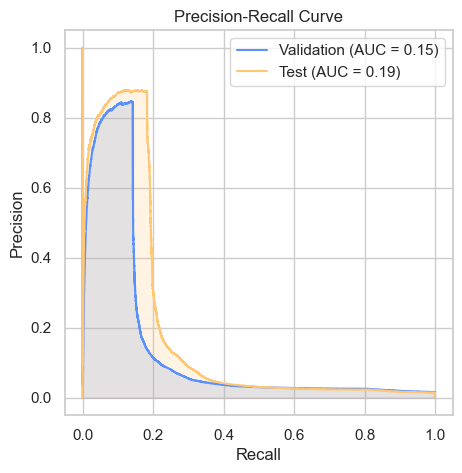

In [22]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.figure(figsize=(5, 5))

sns.lineplot(x=val_recall, y=val_precision, color='#5890FE', label=f'Validation (AUC = {val_auc:.2f})', estimator=None)
plt.fill_between(val_recall, val_precision, alpha=0.2, color='#5890FE')

sns.lineplot(x=test_recall, y=test_precision, color='#FFC773', label=f'Test (AUC = {test_auc:.2f})', estimator=None)
plt.fill_between(test_recall, test_precision, alpha=0.2, color='#FFC773')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [23]:
tmp = {
    'precision': [],
    'recall': [],
    'split': [],
    'anomaly': [],
}

for anomaly_type in range(1,6):
    b_val = np.array(val_anomaly == 0) | np.array(val_anomaly == anomaly_type)
    b_test = np.array(test_anomaly == 0) | np.array(test_anomaly == anomaly_type)
    
    val_precision, val_recall, _ = precision_recall_curve(val_labels[b_val], np.array(val_probabilities)[b_val])
    test_precision, test_recall, _ = precision_recall_curve(test_labels[b_test], np.array(test_probabilities)[b_test])
    
    tmp['precision'].extend(val_precision)
    tmp['recall'].extend(val_recall)
    tmp['split'].extend(['validation'] * len(val_precision))
    tmp['anomaly'].extend([anomaly_type] * len(val_precision))
    
    tmp['precision'].extend(test_precision)
    tmp['recall'].extend(test_recall)
    tmp['split'].extend(['test'] * len(test_precision))
    tmp['anomaly'].extend([anomaly_type] * len(test_precision))

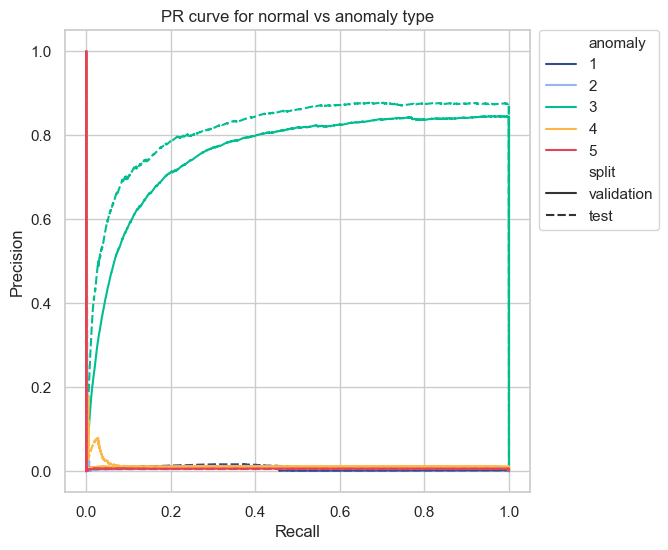

In [24]:
plotsize(6,6)
sns.set_style("whitegrid")

anomaly_df = pl.DataFrame(tmp)
sns.lineplot(
    data=anomaly_df, x='recall', y='precision', hue='anomaly', style='split',
    palette=sns.color_palette(['#324D95', '#98B5EB', '#00BE90', '#FFB646', '#E44356'])
)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve for normal vs anomaly type')
plt.show()

# DIME results

In [25]:
chosen_model = RESULTS_DIR / 'amaretto/dime'

val_path = chosen_model / "val.npz"
test_path = chosen_model / "test.npz"

val_results = np.load(val_path)
test_results = np.load(test_path)

confidences = val_results['confidences']
probabilities = val_results['probabilities']
queried_features = val_results['queried_features']

test_confidences = test_results['confidences']
test_probabilities = test_results['probabilities']
test_queried_features = test_results['queried_features']

## Analysis of features queried

In [26]:
# fill in the last feature that is missing in results

last_queried_feature = []
for row in tqdm(queried_features.transpose()):
   ix = set(range(0, 91)).difference(set(row[:-1]))
   last_queried_feature.append(next(iter(ix), -1))
   
queried_features[-1, :] = np.array(last_queried_feature)

last_queried_feature = []
for row in tqdm(test_queried_features.transpose()):
   ix = set(range(0, 91)).difference(set(row[:-1]))
   last_queried_feature.append(next(iter(ix), -1))
   
test_queried_features[-1, :] = np.array(last_queried_feature)

100%|██████████| 3224603/3224603 [00:31<00:00, 101012.60it/s]


### Number of unique features queried given budget

In [27]:
unique_set = set()
n_unique = []
for i in tqdm(range(probabilities.shape[0])):
    s = set(queried_features[i, :])
    unique_set = unique_set.union(s)
    n_unique.append(len(unique_set))
    
test_unique_set = set()
test_n_unique = []
for i in tqdm(range(test_probabilities.shape[0])):
    s = set(test_queried_features[i, :])
    test_unique_set = test_unique_set.union(s)
    test_n_unique.append(len(test_unique_set))

100%|██████████| 92/92 [00:18<00:00,  5.03it/s]


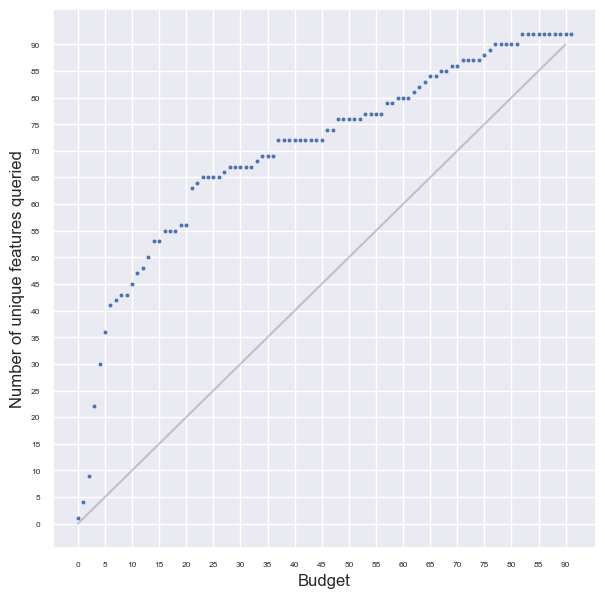

In [28]:
plotsize(7,7)
sns.scatterplot(n_unique, s=10)
# sns.scatterplot(test_n_unique, s=6)
sns.lineplot(x=range(0, 91), y=range(0, 91), c='grey', alpha=0.4)
plt.yticks(range(0,92,5),fontsize=6)
plt.xticks(range(0,92,5),fontsize=6)
plt.xlabel('Budget')
plt.ylabel('Number of unique features queried')
plt.show()

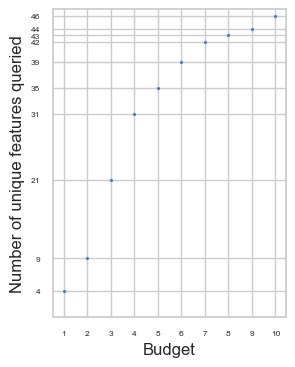

In [29]:
plotsize(3,4)
sns.set_style('whitegrid')
sns.scatterplot(x=range(1,11), y=test_n_unique[1:11], s=6)
plt.ylim(0, 47)
plt.yticks(test_n_unique[1:11],fontsize=6)
plt.xticks(range(1,11),fontsize=6)
plt.xlabel('Budget')
plt.ylabel('Number of unique features queried')
plt.show()

### Which features are queried and when

We want to analyze which features are needed for correct classification and how it is influenced by the anomaly type of the feature.

#### Full dataset

In [30]:
from matplotlib.colors import LogNorm

# Assuming queried_features is defined and accessible.
tmp = {'position': [], 'feature': [], 'count': []}
for k in range(1, 11):
    c = Counter(test_queried_features[k, :])
    for feature, count in c.items():
        tmp['position'].append(k)
        tmp['feature'].append(feature)
        tmp['count'].append(count)

df = pd.DataFrame(tmp)

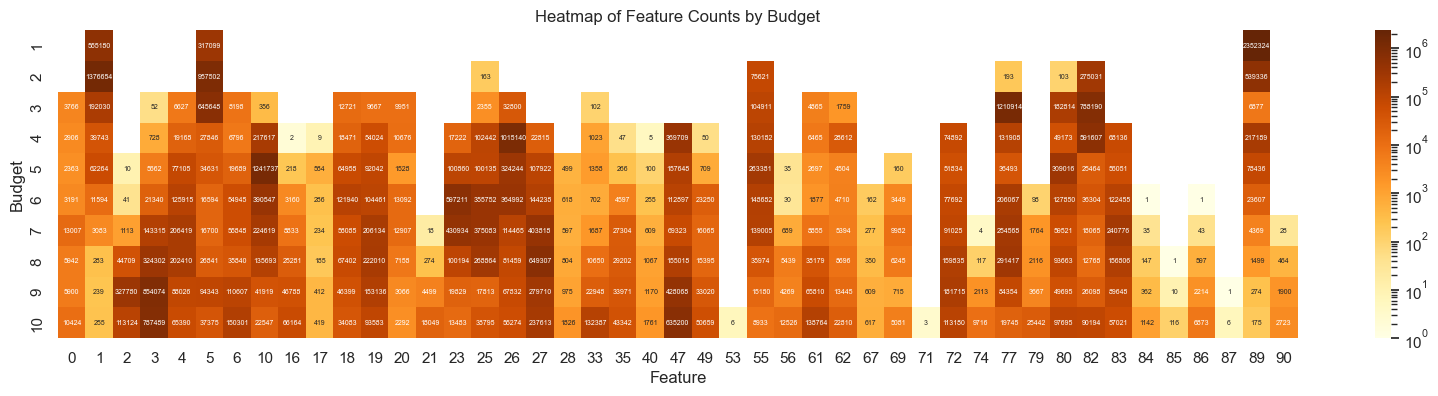

In [31]:
plotsize(20, 4)
sns.set_style("white")

pivot_df = df.pivot(index='position', columns='feature', values='count')
sns.heatmap(pivot_df, norm=LogNorm(), cmap="YlOrBr", annot=True, fmt=".0f", annot_kws={"size": 5})
plt.title("Heatmap of Feature Counts by Budget")
plt.xlabel("Feature")
plt.ylabel("Budget")
plt.show()


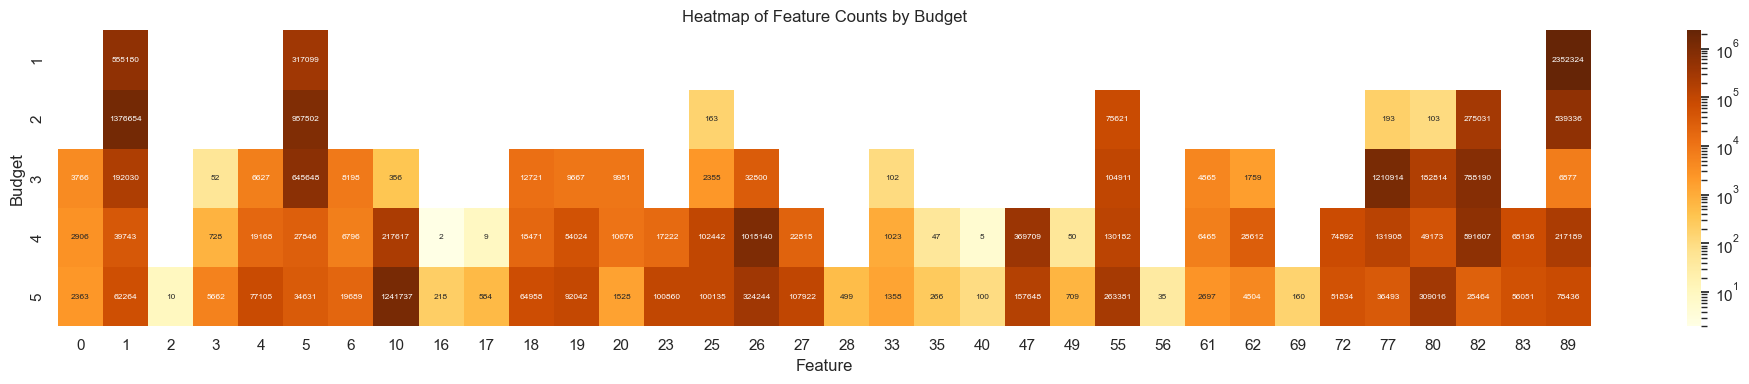

In [32]:
plotsize(20, 4)
sns.set_style("white")

pivot_df = df[df['position'] < 6].pivot(index='position', columns='feature', values='count')

sns.heatmap(pivot_df, norm=LogNorm(), cmap="YlOrBr", annot=True, fmt=".0f", annot_kws={"size": 6})
plt.title("Heatmap of Feature Counts by Budget")
plt.xlabel("Feature")
plt.ylabel("Budget")
plt.tight_layout()
plt.show()

#### Compare different types

In [33]:
from matplotlib.colors import LogNorm

# Assuming queried_features is defined and accessible.
tmp = {'position': [], 'feature': [], 'count': [], 'anomaly': []}

for anomaly_type in range(6):
    for k in range(1, 11):
        b = np.array(val_anomaly == anomaly_type)
        c = Counter(queried_features[k, :][b])
        for feature, count in c.items():
            tmp['position'].append(k)
            tmp['feature'].append(feature)
            tmp['count'].append(count)
            tmp['anomaly'].append(anomaly_type)

df = pd.DataFrame(tmp)

In [34]:
plotsize(20, 4)
sns.set_style("white")

pivots = []

for anomaly_type in range(6):
    filtered_df = df[df['position'] < 10]
    filtered_df = filtered_df[filtered_df['anomaly'] == anomaly_type]
    pivot_df = filtered_df.pivot(index='position', columns='feature', values='count')
    pivots.append(pivot_df)
    
common_cols = sorted(
    set(pivots[0].columns) | set(pivots[1].columns) |
    set(pivots[2].columns) | set(pivots[3].columns) |
    set(pivots[4].columns) | set(pivots[5].columns)
)

for (i, pivot) in enumerate(pivots):
    pivots[i] = pivot.reindex(columns=common_cols)

# pivot_df1 = pivot_df1.reindex(columns=common_cols)
# pivot_df2 = pivot_df2.reindex(columns=common_cols)

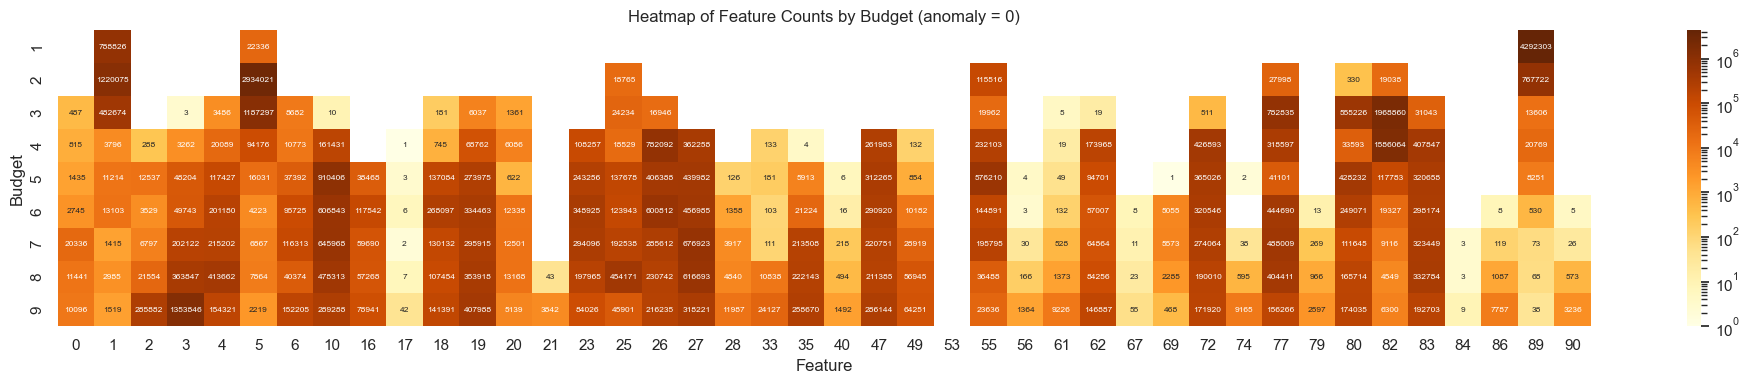

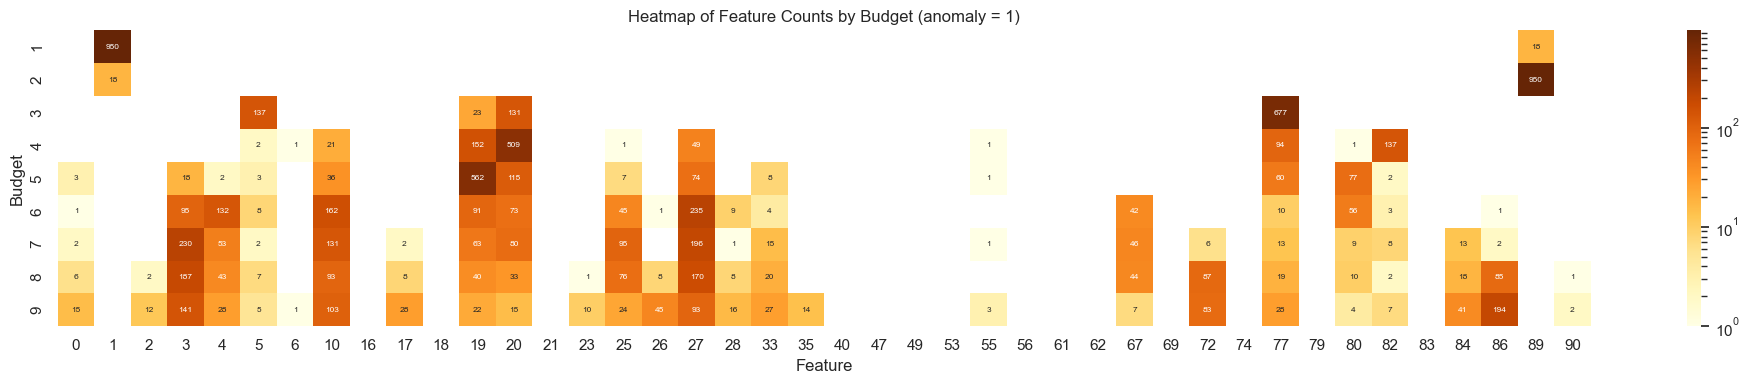

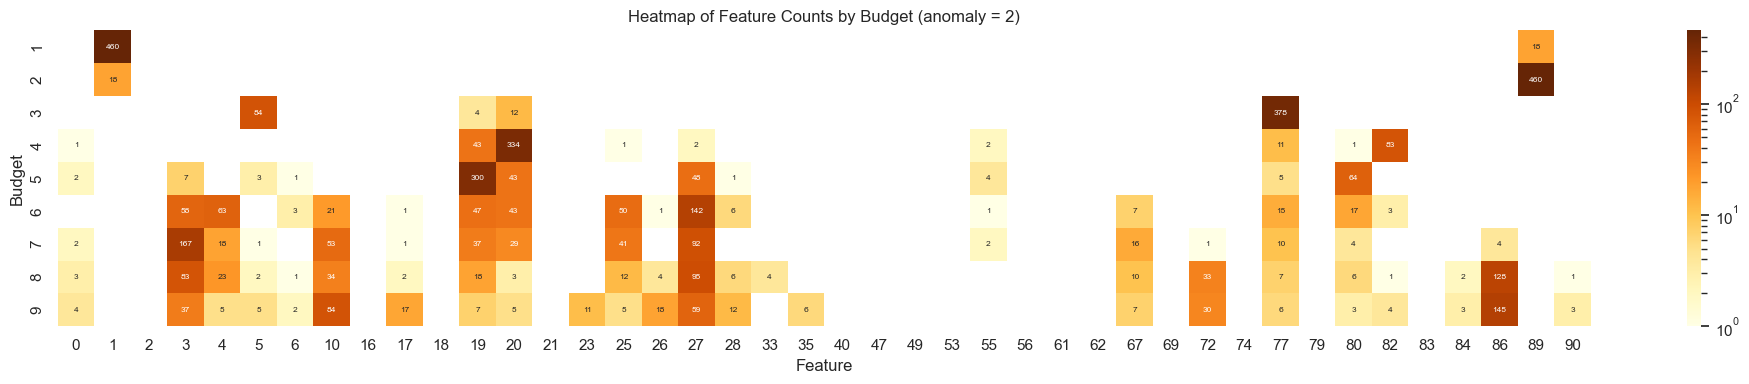

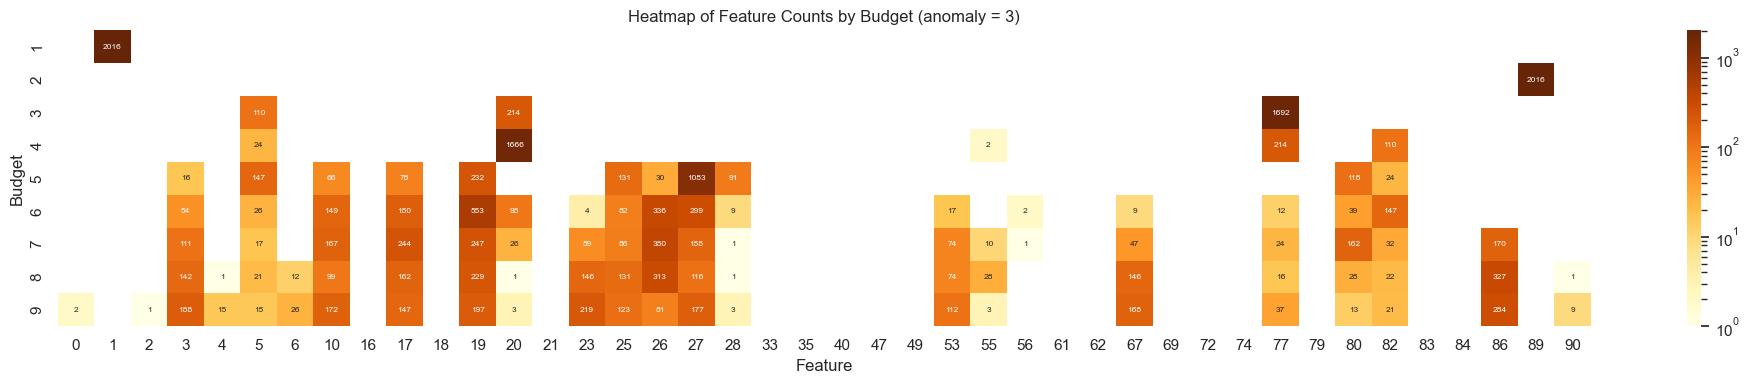

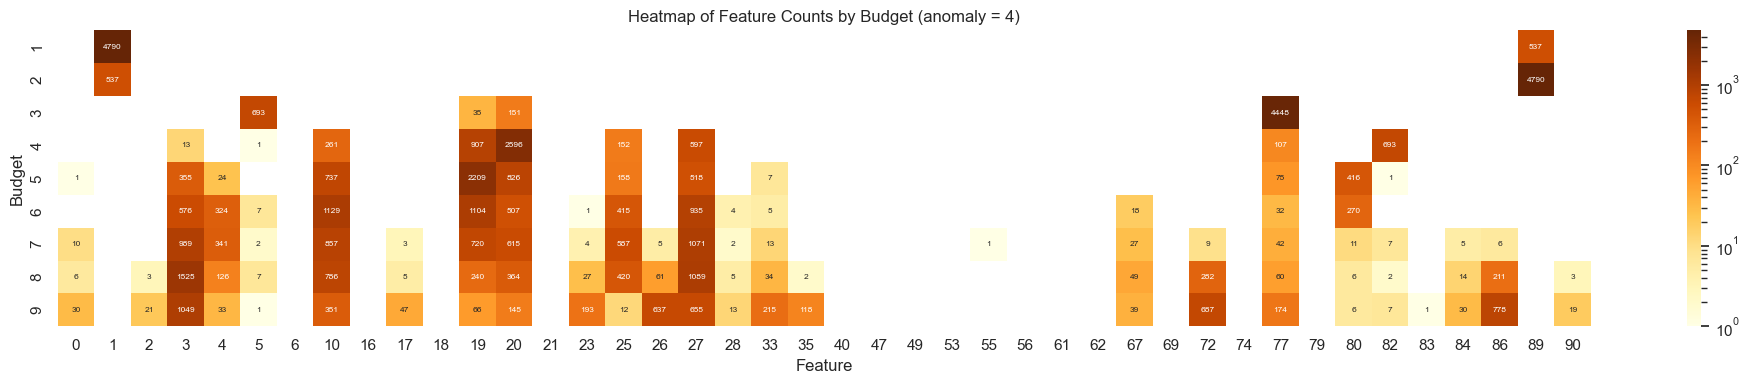

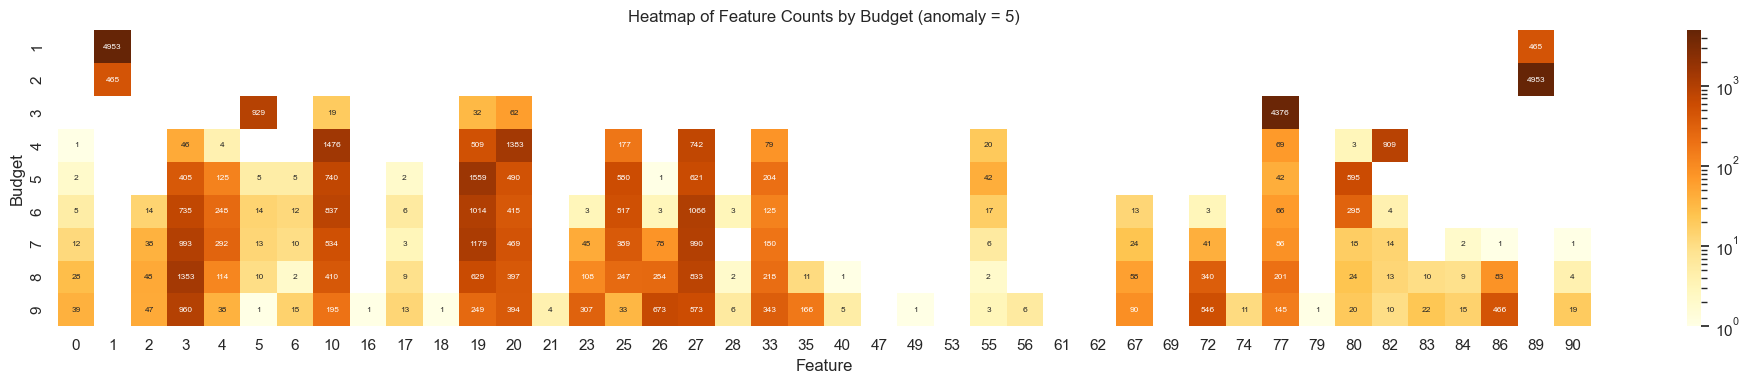

In [35]:
for (anomaly_type, pivot_df) in enumerate(pivots):
    sns.heatmap(pivot_df, norm=LogNorm(), cmap="YlOrBr", annot=True, fmt=".0f", annot_kws={"size": 6})
    plt.title(f"Heatmap of Feature Counts by Budget (anomaly = {anomaly_type})")
    plt.xlabel("Feature")
    plt.ylabel("Budget")
    plt.tight_layout()
    plt.show()

#### Normal vs all anomalies

In [36]:
from matplotlib.colors import LogNorm


tmp = {'position': [], 'feature': [], 'count': [], 'anomaly': []}

for k in range(1, 11):
    b = np.array(test_anomaly == 0)
    c = Counter(test_queried_features[k, :][b])
    for feature, count in c.items():
        tmp['position'].append(k)
        tmp['feature'].append(feature)
        tmp['count'].append(count)
        tmp['anomaly'].append('normal')
        
for k in range(1, 11):
    b = np.array(test_anomaly != 0)
    c = Counter(test_queried_features[k, :][b])
    for feature, count in c.items():
        tmp['position'].append(k)
        tmp['feature'].append(feature)
        tmp['count'].append(count)
        tmp['anomaly'].append('anomaly')

df = pd.DataFrame(tmp)

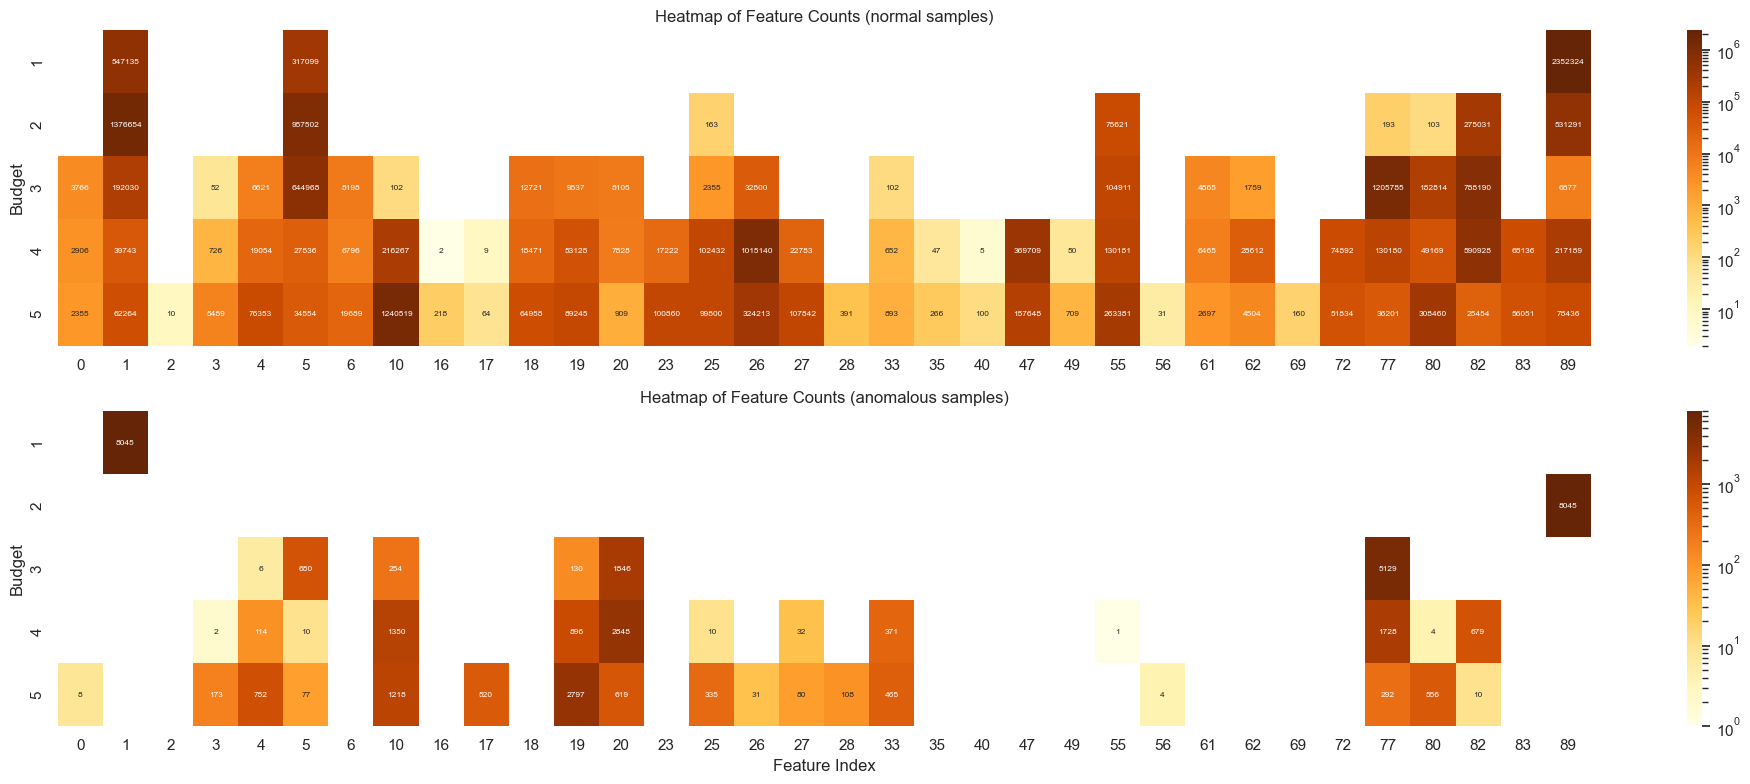

In [37]:
plotsize(20, 8)
sns.set_style("white")

max_budget = 5

filtered_df = df[df['position'] <= max_budget]
filtered_df = filtered_df[filtered_df['anomaly'] == 'normal']
pivot_df1 = filtered_df.pivot(index='position', columns='feature', values='count')

filtered_df = df[df['position'] <= max_budget]
filtered_df = filtered_df[filtered_df['anomaly'] == 'anomaly']
pivot_df2 = filtered_df.pivot(index='position', columns='feature', values='count')

common_cols = sorted(set(pivot_df1.columns) | set(pivot_df2.columns))
pivot_df1 = pivot_df1.reindex(columns=common_cols)
pivot_df2 = pivot_df2.reindex(columns=common_cols)

plt.subplot(2,1,1)
sns.heatmap(pivot_df1, norm=LogNorm(), cmap="YlOrBr", annot=True, fmt=".0f", annot_kws={"size": 6})
plt.title("Heatmap of Feature Counts (normal samples)")
plt.xlabel("")
plt.ylabel("Budget")

plt.subplot(2,1,2)
sns.heatmap(pivot_df2, norm=LogNorm(), cmap="YlOrBr", annot=True, fmt=".0f", annot_kws={"size": 6})
plt.title("Heatmap of Feature Counts (anomalous samples)")
plt.xlabel("Feature Index")
plt.ylabel("Budget")
plt.tight_layout()
plt.show()

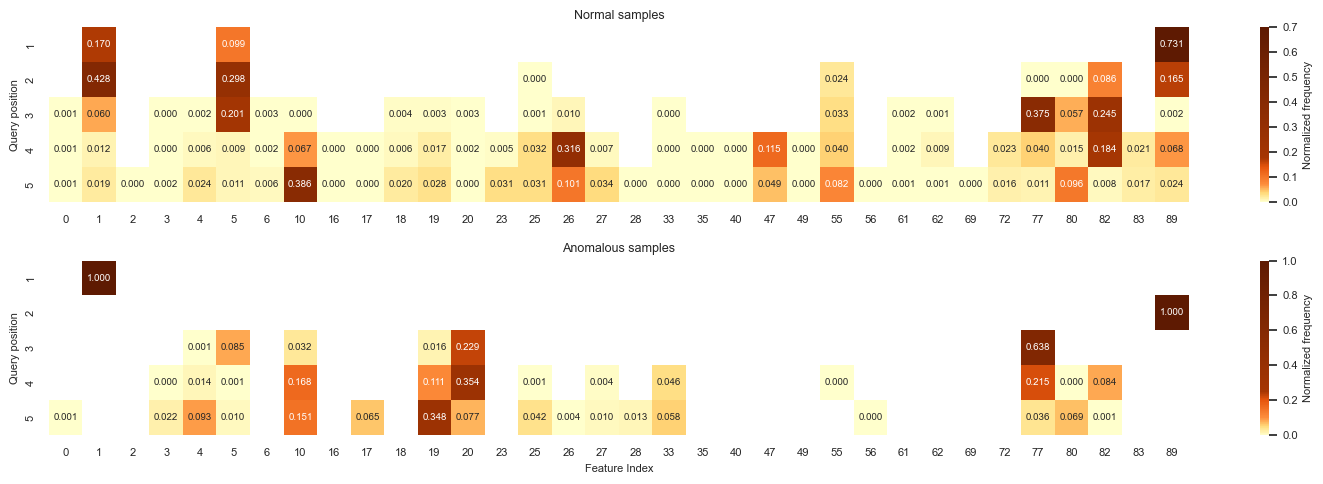

In [38]:
from matplotlib.colors import LinearSegmentedColormap, LogNorm

# Create a custom colormap with higher contrast
colors = ['#FFFFCC', '#FFDA7A', '#FD8D3C', '#E6550D', '#A63603', '#5E1A02']
positions = [0, 0.05, 0.1, 0.2, 0.25, 1.0] # Positions in the colorscale
custom_cmap = LinearSegmentedColormap.from_list('custom', list(zip(positions, colors)))

plotsize(15, 5)
sns.set_style("white")

# Prepare data
max_budget = 5
filtered_df = df[df['position'] <= max_budget]
filtered_df_normal = filtered_df[filtered_df['anomaly'] == 'normal']
pivot_df1 = filtered_df_normal.pivot(index='position', columns='feature', values='count')

filtered_df_anomaly = filtered_df[filtered_df['anomaly'] == 'anomaly']
pivot_df2 = filtered_df_anomaly.pivot(index='position', columns='feature', values='count')

# Ensure both pivot tables have the same columns
common_cols = sorted(set(pivot_df1.columns) | set(pivot_df2.columns))
pivot_df1 = pivot_df1.reindex(columns=common_cols)
pivot_df2 = pivot_df2.reindex(columns=common_cols)

# Calculate row sums for normalization (if you want normalized frequencies)
# Comment these out if you want raw counts like in your original code
pivot_df1_pct = pivot_df1.div(pivot_df1.sum(axis=1), axis=0)
pivot_df2_pct = pivot_df2.div(pivot_df2.sum(axis=1), axis=0)

plt.subplots_adjust(hspace=0.3)

cbar_kws = {
    # 'label': 'Count (log scale)',  # Modify label based on whether you're using raw or normalized data
    'label': 'Normalized frequency',  # Modify label based on whether you're using raw or normalized data
    'ticks': None,  # Let matplotlib determine appropriate ticks for log scale
}

# First subplot
plt.subplot(2, 1, 1)
# Use pivot_df1 for raw counts or pivot_df1_pct for normalized values
ax1 = sns.heatmap(
    # pivot_df1,  # or pivot_df1_pct for normalized values
    pivot_df1_pct,  # or pivot_df1_pct for normalized values
    cmap=custom_cmap,
    annot=True,
    fmt=".3f",  # Use ".3f" if using normalized values
    annot_kws={'size': 7},
    # norm=LogNorm(),  # Keep the log normalization
    cbar_kws=cbar_kws,
    vmin=0,
    vmax=0.7,
)
plt.title('Normal samples', fontsize=9)
plt.ylabel('Query position', fontsize=8)
plt.xlabel('', fontsize=8)

# Set tick font sizes for first subplot
# Set tick font sizes for second subplot
ax1.tick_params(axis='both', which='major', labelsize=8)

# Get the colorbar and set its tick label size and label font size
cbar = ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.yaxis.label.set_size(8)  # Set the colorbar label font size

# Second subplot
plt.subplot(2, 1, 2)
# Define colorbar properties including label

ax2 = sns.heatmap(
    # pivot_df2,  # or pivot_df2_pct for normalized values
    pivot_df2_pct,  # or pivot_df2_pct for normalized values
    cmap=custom_cmap,
    annot=True,
    fmt=".3f",  # Use ".3f" if using normalized values
    annot_kws={'size': 7},
    # norm=LogNorm(),  # Keep the log normalization
    cbar_kws=cbar_kws,
    vmin=0,
    vmax=1,
)
plt.title('Anomalous samples', fontsize=9)
plt.xlabel('Feature Index', fontsize=8)
plt.ylabel('Query position', fontsize=8)

# Set tick font sizes for second subplot
ax2.tick_params(axis='both', which='major', labelsize=8)

# Get the colorbar and set its tick label size and label font size
cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.yaxis.label.set_size(8)  # Set the colorbar label font size

plt.tight_layout()
plt.show()

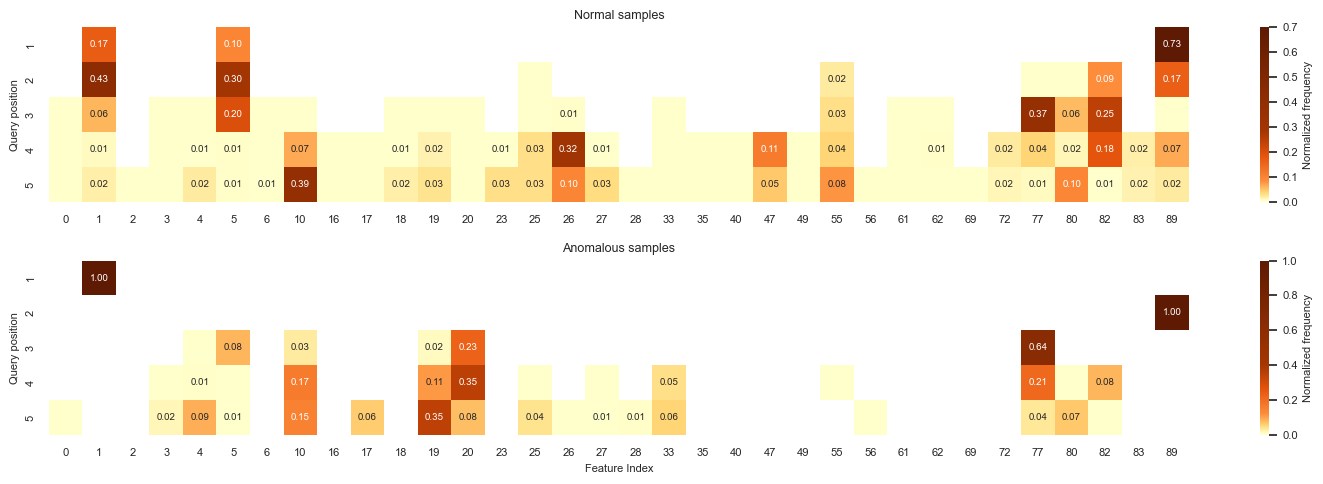

In [39]:
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np

# Create a custom colormap with higher contrast
colors = ['#FFFFCC', '#FFFFCC', '#FFDA7A', '#FD8D3C', '#E6550D', '#A63603', '#5E1A02']
positions = [0, 0.01, 0.05, 0.12, 0.26, 0.4, 1.0] # Positions in the colorscale
custom_cmap = LinearSegmentedColormap.from_list('custom', list(zip(positions, colors)))

plotsize(15, 5)
sns.set_style("white")

# Prepare data
max_budget = 5
filtered_df = df[df['position'] <= max_budget]
filtered_df_normal = filtered_df[filtered_df['anomaly'] == 'normal']
pivot_df1 = filtered_df_normal.pivot(index='position', columns='feature', values='count')
filtered_df_anomaly = filtered_df[filtered_df['anomaly'] == 'anomaly']
pivot_df2 = filtered_df_anomaly.pivot(index='position', columns='feature', values='count')

# Ensure both pivot tables have the same columns
common_cols = sorted(set(pivot_df1.columns) | set(pivot_df2.columns))
pivot_df1 = pivot_df1.reindex(columns=common_cols)
pivot_df2 = pivot_df2.reindex(columns=common_cols)

# Calculate row sums for normalization
pivot_df1_pct = pivot_df1.div(pivot_df1.sum(axis=1), axis=0)
pivot_df2_pct = pivot_df2.div(pivot_df2.sum(axis=1), axis=0)

plt.subplots_adjust(hspace=0.3)

cbar_kws = {
    'label': 'Normalized frequency',
    'ticks': None,
}

# First subplot
plt.subplot(2, 1, 1)
ax1 = sns.heatmap(
    pivot_df1_pct,
    cmap=custom_cmap,
    annot=True,
    fmt=".2f",
    annot_kws={'size': 7},
    mask=None,  # Don't mask the heatmap itself
    cbar_kws=cbar_kws,
    vmin=0,
    vmax=0.7,
)

# Apply the annotation mask after creating the heatmap
for text in ax1.texts:
    if float(text.get_text()) < 0.01:
        text.set_text("")  # Hide annotation if value is below threshold

plt.title('Normal samples', fontsize=9)
plt.ylabel('Query position', fontsize=8)
plt.xlabel('', fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=8)
cbar = ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.yaxis.label.set_size(8)

# Second subplot
plt.subplot(2, 1, 2)
ax2 = sns.heatmap(
    pivot_df2_pct,
    cmap=custom_cmap,
    annot=True,
    fmt=".2f",
    annot_kws={'size': 7},
    mask=None,  # Don't mask the heatmap itself
    cbar_kws=cbar_kws,
    vmin=0,
    vmax=1,
)

# Apply the annotation mask after creating the heatmap
for text in ax2.texts:
    if float(text.get_text()) < 0.01:
        text.set_text("")  # Hide annotation if value is below threshold

plt.title('Anomalous samples', fontsize=9)
plt.xlabel('Feature Index', fontsize=8)
plt.ylabel('Query position', fontsize=8)
ax2.tick_params(axis='both', which='major', labelsize=8)
cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.yaxis.label.set_size(8)

plt.tight_layout()
plt.savefig('feature_counts_comparison.pdf')
plt.show()

In [40]:
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np

# Create a custom colormap with higher contrast
colors = ['#FFFFCC', '#FFFFCC', '#FFDA7A', '#FD8D3C', '#E6550D', '#A63603', '#5E1A02']
positions = [0, 0.05, 0.1, 0.18, 0.27, 0.6, 1.0] # Positions in the colorscale
custom_cmap = LinearSegmentedColormap.from_list('custom', list(zip(positions, colors)))

plotsize(11, 5)
sns.set_style("white")

# Prepare data
max_budget = 5
filtered_df = df[df['position'] <= max_budget]
filtered_df_normal = filtered_df[filtered_df['anomaly'] == 'normal']
pivot_df1 = filtered_df_normal.pivot(index='position', columns='feature', values='count')
filtered_df_anomaly = filtered_df[filtered_df['anomaly'] == 'anomaly']
pivot_df2 = filtered_df_anomaly.pivot(index='position', columns='feature', values='count')

# Ensure both pivot tables have the same columns
common_cols = sorted(set(pivot_df1.columns) | set(pivot_df2.columns))
pivot_df1 = pivot_df1.reindex(columns=common_cols)
pivot_df2 = pivot_df2.reindex(columns=common_cols)

# Calculate row sums for normalization
pivot_df1_pct = pivot_df1.div(pivot_df1.sum(axis=1), axis=0)
pivot_df2_pct = pivot_df2.div(pivot_df2.sum(axis=1), axis=0)

b1 = pl.DataFrame(pivot_df1_pct.fillna(0)).select(pl.col('*').sum()).to_numpy().flatten() > 0.1
b2 = pl.DataFrame(pivot_df2_pct.fillna(0)).select(pl.col('*').sum()).to_numpy().flatten() > 0.1
b = b1 | b2

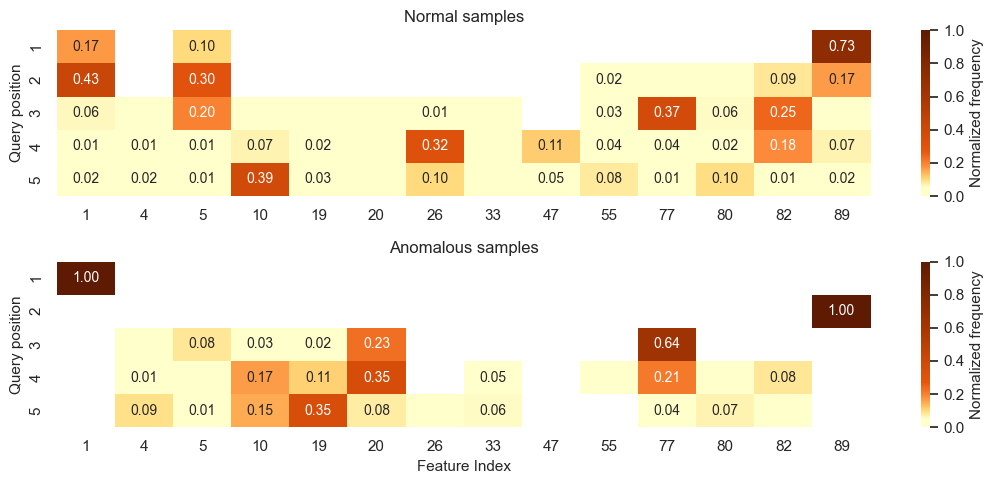

In [41]:
plt.subplots_adjust(hspace=0.3)

cbar_kws = {
    'label': 'Normalized frequency',
    'ticks': None,
}

# First subplot
plt.subplot(2, 1, 1)
ax1 = sns.heatmap(
    pivot_df1_pct.iloc[:, b],
    cmap=custom_cmap,
    annot=True,
    fmt=".2f",
    annot_kws={'size': 10},
    mask=None,  # Don't mask the heatmap itself
    cbar_kws=cbar_kws,
    vmin=0,
    vmax=1,
)

# Apply the annotation mask after creating the heatmap
for text in ax1.texts:
    if float(text.get_text()) < 0.01:
        text.set_text("")  # Hide annotation if value is below threshold

plt.title('Normal samples', fontsize=12)
plt.ylabel('Query position', fontsize=11)
plt.xlabel('', fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=11)
cbar = ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)
cbar.ax.yaxis.label.set_size(11)

# Second subplot
plt.subplot(2, 1, 2)
ax2 = sns.heatmap(
    pivot_df2_pct.iloc[:, b],
    cmap=custom_cmap,
    annot=True,
    fmt=".2f",
    annot_kws={'size': 10},
    mask=None,  # Don't mask the heatmap itself
    cbar_kws=cbar_kws,
    vmin=0,
    vmax=1,
)

# Apply the annotation mask after creating the heatmap
for text in ax2.texts:
    if float(text.get_text()) < 0.01:
        text.set_text("")  # Hide annotation if value is below threshold

plt.title('Anomalous samples', fontsize=12)
plt.xlabel('Feature Index', fontsize=11)
plt.ylabel('Query position', fontsize=11)
ax2.tick_params(axis='both', which='major', labelsize=11)
cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)
cbar.ax.yaxis.label.set_size(11)

plt.tight_layout()
plt.savefig('feature_counts_comparison_smaller.pdf')
plt.show()

## Budget analysis

In [42]:
# Function to remove redundant points (consecutive duplicates)
def filter_duplicate_points(recall, precision):
    unique_indices = np.where(np.diff(precision) > 1e-6)[0] + 1  # Find unique recall points
    return recall[unique_indices], precision[unique_indices]

# Function to downsample the PR curve to a fixed number of points
def subsample_curve(recall, precision, num_points=500):
    if len(recall) <= num_points:
        return recall, precision  # No need to downsample
    indices = np.linspace(0, len(recall) - 1, num_points, dtype=int)  # Uniform subsampling
    return recall[indices], precision[indices]

Plotting PR Curves: 100%|██████████| 92/92 [02:00<00:00,  1.31s/it]


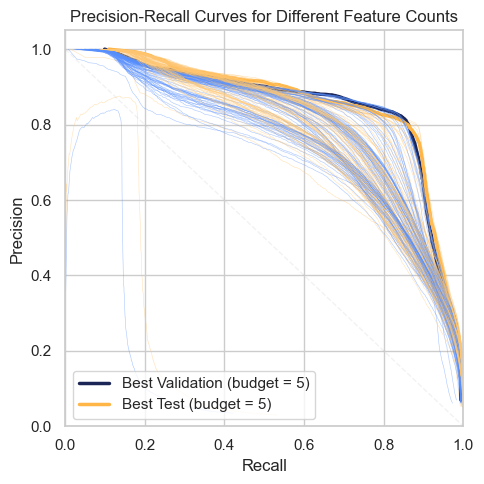

In [43]:
# Create figure
sns.set_style("whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(5, 5))

# Compute and plot PR curves iteratively (memory-efficient)
for i in tqdm(range(probabilities.shape[0]), desc="Plotting PR Curves"):
    # Compute PR curves on the fly
    val_precision, val_recall, _ = precision_recall_curve(val_labels, probabilities[i, :])
    test_precision, test_recall, _ = precision_recall_curve(test_labels, test_probabilities[i, :])

    # Remove redundant points
    val_recall, val_precision = filter_duplicate_points(val_recall, val_precision)
    test_recall, test_precision = filter_duplicate_points(test_recall, test_precision)

    # Subsample to reduce the number of points plotted
    val_recall, val_precision = subsample_curve(val_recall, val_precision, num_points=10_000)
    test_recall, test_precision = subsample_curve(test_recall, test_precision, num_points=10_000)

    # Plot the best curve with emphasis
    if i == 5:
        ax.plot(val_recall, val_precision, color='#1B2556', linewidth=2.5, label='Best Validation (budget = 5)')
        ax.plot(test_recall, test_precision, color='#FFB646', linewidth=2.5, label='Best Test (budget = 5)')
    else:
        ax.plot(val_recall, val_precision, color='#5890FE', alpha=0.5, linewidth=0.4)
        ax.plot(test_recall, test_precision, color='#FFC773', alpha=0.5, linewidth=0.4)

# Customize the plot
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves for Different Feature Counts')
ax.legend(loc='lower left')

# Optional: Add diagonal reference line
ax.plot([0, 1], [1, 0], '--', linewidth=1, alpha=0.1, color='grey')

# Set axis limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

## Results based on anomaly type

### Confusion matrix

In [44]:
budget = 5
_f1, thr = f1_smart(val_labels, probabilities[budget, :])
predicted_labels = probabilities[budget, :] >= thr

In [45]:
# Create a DataFrame to hold the confusion matrix with rows for true labels 0 to 5
labels = np.arange(6)
confusion = pd.DataFrame(index=labels, columns=["fp", "tp"], data=0)

# Calculate for the normal class (label 0)
normal_mask = (val_anomaly == 0)
confusion.loc[0, "fp"] = np.sum(predicted_labels[normal_mask] == 1)
confusion.loc[0, "tp"] = np.sum(predicted_labels[normal_mask] == 0)

# Calculate for the anomaly classes (labels 1 to 5)
for lab in range(1, 6):
    lab_mask = (val_anomaly == lab)
    confusion.loc[lab, "tp"] = np.sum(predicted_labels[lab_mask] == 1)
    confusion.loc[lab, "fp"] = np.sum(predicted_labels[lab_mask] == 0)

print(confusion)

     fp       tp
0  2752  5100713
1   161      807
2   101      377
3    24     1992
4   714     4613
5  1093     4325


### PR curves per anomaly class

In [46]:
tmp = {
    'precision': [],
    'recall': [],
    'split': [],
    'anomaly': [],
}

for anomaly_type in range(1,6):
    b_val = np.array(val_anomaly == 0) | np.array(val_anomaly == anomaly_type)
    b_test = np.array(test_anomaly == 0) | np.array(test_anomaly == anomaly_type)
    
    val_precision, val_recall, _ = precision_recall_curve(val_labels[b_val], probabilities[budget, :][b_val])
    test_precision, test_recall, _ = precision_recall_curve(test_labels[b_test], test_probabilities[budget, :][b_test])
    
    tmp['precision'].extend(val_precision)
    tmp['recall'].extend(val_recall)
    tmp['split'].extend(['validation'] * len(val_precision))
    tmp['anomaly'].extend([anomaly_type] * len(val_precision))
    
    tmp['precision'].extend(test_precision)
    tmp['recall'].extend(test_recall)
    tmp['split'].extend(['test'] * len(test_precision))
    tmp['anomaly'].extend([anomaly_type] * len(test_precision))

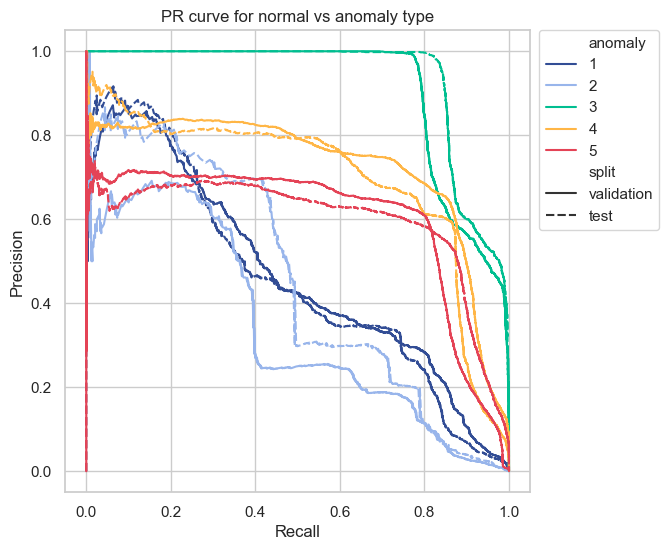

In [47]:
plotsize(6,6)
sns.set_style("whitegrid")

anomaly_df = pl.DataFrame(tmp)
sns.lineplot(
    data=anomaly_df, x='recall', y='precision', hue='anomaly', style='split',
    palette=sns.color_palette(['#324D95', '#98B5EB', '#00BE90', '#FFB646', '#E44356'])
)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve for normal vs anomaly type')
plt.show()

# Final results tables

In [48]:
new_models = {}
for key in models:
    if 'dime' not in key:
        new_models[key] = models[key]
models = new_models

In [49]:
for i in range(0,11):
    models[f'dime_budget_{i}'] = (probabilities[i, :], test_probabilities[i, :])

In [50]:
models.keys()

dict_keys(['full_classifier', '2f_classifier', 'prior_classifier', 'dime_budget_0', 'dime_budget_1', 'dime_budget_2', 'dime_budget_3', 'dime_budget_4', 'dime_budget_5', 'dime_budget_6', 'dime_budget_7', 'dime_budget_8', 'dime_budget_9', 'dime_budget_10'])

In [51]:
# Function to compute recall at a fixed precision
def recall_at_precision(y_true, y_scores, target_precision):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    valid_recall = recall[precision >= target_precision]
    return max(valid_recall) if len(valid_recall) > 0 else 0.0

# Function to compute precision at a fixed recall
def precision_at_recall(y_true, y_scores, target_recall):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    valid_precision = precision[recall >= target_recall]
    return max(valid_precision) if len(valid_precision) > 0 else 0.0

val_metrics = []
test_metrics = []

for model_name, (val_probs, test_probs) in tqdm(models.items()):
    
    if 'dime_budget' in model_name:
        splits = model_name.split('_')
        model_name = f'DIME (budget = {splits[-1]})'
    
    ap = average_precision_score(val_labels, val_probs)
    recall_99_precision = recall_at_precision(val_labels, val_probs, 0.99)
    recall_90_precision = recall_at_precision(val_labels, val_probs, 0.90)
    precision_50_recall = precision_at_recall(val_labels, val_probs, 0.50)
    precision_80_recall = precision_at_recall(val_labels, val_probs, 0.80)
    
    val_metrics.append({
        "Model": model_name,
        "AP": ap,
        "Recall @ 99% Precision": recall_99_precision,
        "Recall @ 90% Precision": recall_90_precision,
        "Precision @ 50% Recall": precision_50_recall,
        "Precision @ 80% Recall": precision_80_recall
    })
    
    ap = average_precision_score(test_labels, test_probs)
    recall_99_precision = recall_at_precision(test_labels, test_probs, 0.99)
    recall_90_precision = recall_at_precision(test_labels, test_probs, 0.90)
    precision_50_recall = precision_at_recall(test_labels, test_probs, 0.50)
    precision_80_recall = precision_at_recall(test_labels, test_probs, 0.80)
    
    test_metrics.append({
        "Model": model_name,
        "AP": ap,
        "Recall @ 99% Precision": recall_99_precision,
        "Recall @ 90% Precision": recall_90_precision,
        "Precision @ 50% Recall": precision_50_recall,
        "Precision @ 80% Recall": precision_80_recall
    })

# Convert to DataFrame
val_metrics_df = pl.DataFrame(val_metrics)
test_metrics_df = pl.DataFrame(test_metrics)

100%|██████████| 14/14 [01:42<00:00,  7.35s/it]


In [52]:
val_metrics_df

Model,AP,Recall @ 99% Precision,Recall @ 90% Precision,Precision @ 50% Recall,Precision @ 80% Recall
str,f64,f64,f64,f64,f64
"""full_classifier""",0.847416,0.057648,0.582319,0.91092,0.780043
"""2f_classifier""",0.822579,0.0,0.114662,0.888037,0.833797
"""prior_classifier""",0.147218,0.0,0.0,0.030513,0.025728
"""DIME (budget = 0)""",0.149913,0.0,0.0,0.030844,0.024839
"""DIME (budget = 1)""",0.702095,0.010629,0.162877,0.752966,0.583004
…,…,…,…,…,…
"""DIME (budget = 6)""",0.85506,0.124094,0.498768,0.899747,0.840227
"""DIME (budget = 7)""",0.85374,0.126628,0.494475,0.899887,0.842047
"""DIME (budget = 8)""",0.854776,0.120856,0.512705,0.902218,0.845456


In [53]:
test_metrics_df

Model,AP,Recall @ 99% Precision,Recall @ 90% Precision,Precision @ 50% Recall,Precision @ 80% Recall
str,f64,f64,f64,f64,f64
"""full_classifier""",0.861642,0.091858,0.579739,0.925781,0.779271
"""2f_classifier""",0.829192,0.0,0.122188,0.880444,0.825552
"""prior_classifier""",0.194943,0.0,0.0,0.031107,0.023513
"""DIME (budget = 0)""",0.195719,0.0,0.0,0.032066,0.022509
"""DIME (budget = 1)""",0.703809,0.025482,0.180485,0.738843,0.526505
…,…,…,…,…,…
"""DIME (budget = 6)""",0.85897,0.177502,0.547421,0.914318,0.827356
"""DIME (budget = 7)""",0.854432,0.1688,0.550528,0.916686,0.818957
"""DIME (budget = 8)""",0.854689,0.157613,0.569546,0.91827,0.816487


## PR curves for all models

In [54]:
new_models = {}
for key in models:
    if 'dime' not in key:
        new_models[key] = models[key]
models = new_models

In [55]:
for i in [0, 1, 2, 4, 10]:
    models[f'dime_budget_{i}'] = (probabilities[i, :], test_probabilities[i, :])

In [56]:
dime_colors = [
    '#abdda4',
    '#e6f598',
    '#fee08b',
    '#fdae61',
    '#f46d43',
    '#d53e4f',
    '#9e0142',
]

full_color = '#3288bd'
f2_color = '#5e4fa2'
prior_color = '#7A7A7A'

In [57]:
mmodels = {}
mmodels['prior_classifier'] = models['prior_classifier']
mmodels['full_classifier'] = models['full_classifier']
mmodels['2f_classifier'] = models['2f_classifier']
for i in [0, 1, 2, 4, 10]:
    mmodels[f'dime_budget_{i}'] = (probabilities[i, :], test_probabilities[i, :])

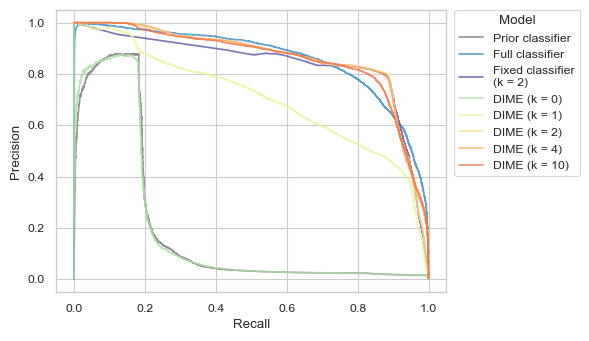

In [58]:
plotsize(6, 3.5)
sns.set_context("paper")
sns.set_style('whitegrid')
sns.despine()

k = 0
for i, (model_name, (val_probs, test_probs)) in enumerate(mmodels.items()):
    precision, recall, thresholds = precision_recall_curve(test_labels, test_probs)
    ap = average_precision_score(test_labels, test_probs)
    
    if 'dime_budget' in model_name:
        splits = model_name.split('_')
        model_name = f'DIME (k = {splits[-1]})'
        color = dime_colors[k]
        k += 1
        
    elif model_name == 'full_classifier':
        model_name = 'Full classifier'
        color = full_color
    
    elif model_name == 'prior_classifier':
        model_name = 'Prior classifier'
        color = prior_color
    
    elif model_name == '2f_classifier':
        model_name = 'Fixed classifier\n(k = 2)'
        color = f2_color
    
    sns.lineplot(x=recall, y=precision, label=model_name, estimator=None, color=color, alpha=0.8)
    # break

plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='Model')
plt.tight_layout()
plt.savefig('amaretto-pr.pdf')
plt.show()

In [59]:
rounded_recall = np.round(recall, 4)
_, indexes_recall, _ = np.unique(rounded_recall, return_index=True, return_inverse=True)
print(len(indexes_recall))

rounded_precision = np.round(precision, 5)
_, indexes_precision, _ = np.unique(rounded_precision, return_index=True, return_inverse=True)
print(len(indexes_precision))

print(len(set(indexes_recall).union(indexes_precision)))
indexes = np.array([x for x in set(indexes_recall).union(indexes_precision)])
indexes = sorted(indexes)

5193
50653
51777


In [60]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

dime_colors = [
    '#abdda4',
    '#e6f598',
    '#fee08b',
    '#fdae61',
    '#f46d43',
    '#d53e4f',
    '#9e0142',
]
dime_colors = [
    '#1d741c',
    '#80b623',
    '#f6c323',
    '#fd7f20',
    '#df362d',
]
full_color = '#3288bd'
f2_color = '#5e4fa2'
prior_color = '#7A7A7A'

fig = go.Figure()

k = 0
for i, (model_name, (val_probs, test_probs)) in enumerate(mmodels.items()):
    precision, recall, thresholds = precision_recall_curve(test_labels, test_probs)
    ap = average_precision_score(test_labels, test_probs)
    
    rounded_recall = np.round(recall, 4)
    _, indexes_recall, _ = np.unique(rounded_recall, return_index=True, return_inverse=True)
    print(len(indexes_recall))

    rounded_precision = np.round(precision, 5)
    _, indexes_precision, _ = np.unique(rounded_precision, return_index=True, return_inverse=True)
    print(len(indexes_precision))

    print(len(set(indexes_recall).union(indexes_precision)))
    indexes = sorted(np.array([x for x in set(indexes_recall).union(indexes_precision)]))
    
    if 'dime_budget' in model_name:
        splits = model_name.split('_')
        model_name = f'DIME (k = {splits[-1]})'
        color = dime_colors[k]
        k += 1
        fig.add_trace(go.Scatter(x=recall[indexes], y=precision[indexes], mode='lines', name=model_name, line=dict(color=color, dash='dot'), opacity=0.7))
    else:
        if model_name == 'full_classifier':
            model_name = 'Full classifier'
            color = full_color
        elif model_name == 'prior_classifier':
            model_name = 'Prior classifier'
            color = prior_color
        elif model_name == '2f_classifier':
            model_name = 'Fixed classifier\n(k = 2)'
            color = f2_color
            
        fig.add_trace(go.Scatter(x=recall[indexes], y=precision[indexes], mode='lines', name=model_name, line=dict(color=color), opacity=0.7))
        

fig.update_layout(
    xaxis_title='Recall',
    yaxis_title='Precision',
    font=dict(
        # family='serif',
        size=12,
    ),
    legend=dict(
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='left',
        x=1,
    ),
    width=650,
    height=350,
    margin=dict(l=50, r=50, t=50, b=50),
    xaxis=dict(
        showgrid=True,
        gridwidth=0.5,
        gridcolor='#CCCCCC',  # Set grid color to a light gray
    ),
    yaxis=dict(
        showgrid=True,
        gridwidth=0.5,
        gridcolor='#CCCCCC',  # Set grid color to a light gray
    ),
    plot_bgcolor='white',  # Set background color to white
    paper_bgcolor='white',  # Set paper background color to white
)

import plotly.offline as pyo
pyo.plot(fig, filename='plot.html', image='svg')

7879
24600
31106
5826
52344
53252
2438
47583
48497
7765
25552
32022
7692
51400
53529
3620
48891
49876
4098
49615
50603
5193
50653
51777


'plot.html'